In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.signal import correlate2d

In [3]:
def normalize(array):
    return (array - np.mean(array)) / np.std(array)

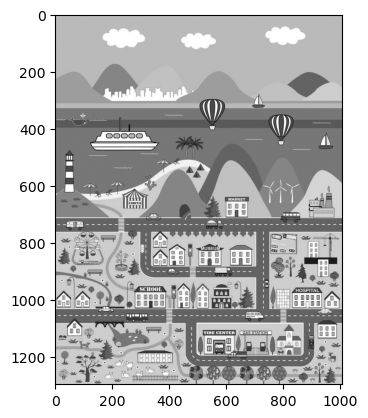

In [4]:
image = cv2.imread('map.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image, 'gray')
plt.show()

In [5]:
baloon = image[297:407,507:597]
nbaloon = normalize(baloon)
nimage = normalize(cv2.equalizeHist(image))

In [6]:
corr_map = correlate2d(nimage, nbaloon)

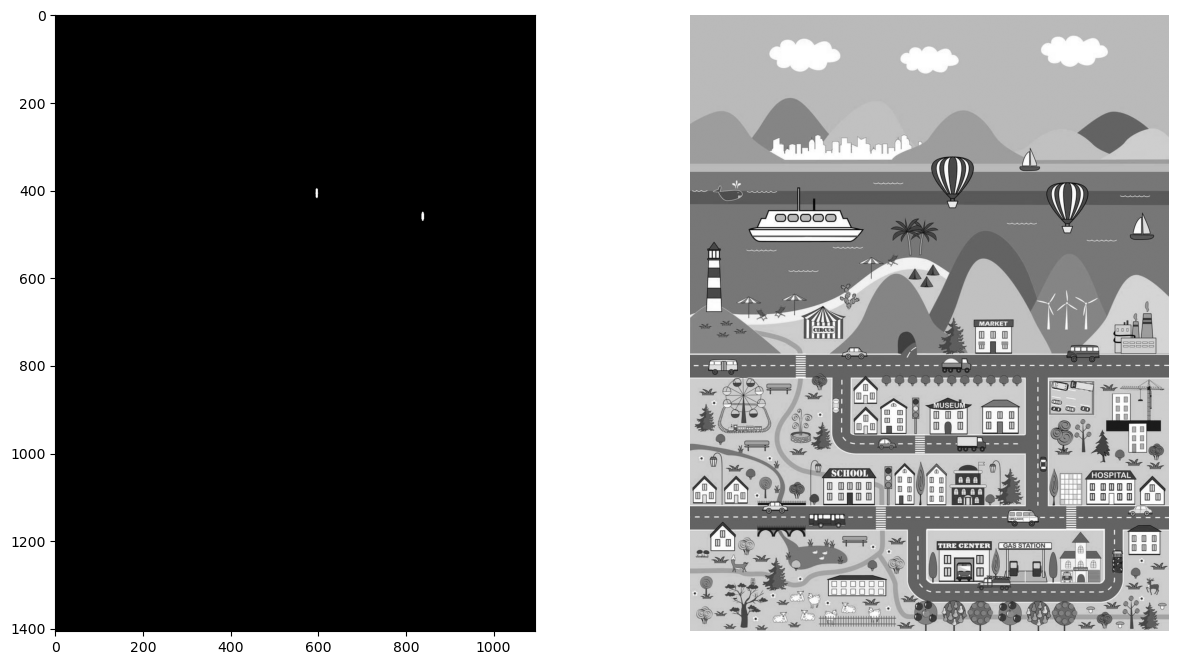

In [7]:
res = (corr_map >= 3000).astype(np.uint8)
_, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
ax1.imshow(res, 'gray', vmin=0, vmax=1)
ax2.axis('off')
ax2.imshow(image , 'gray')
plt.show()

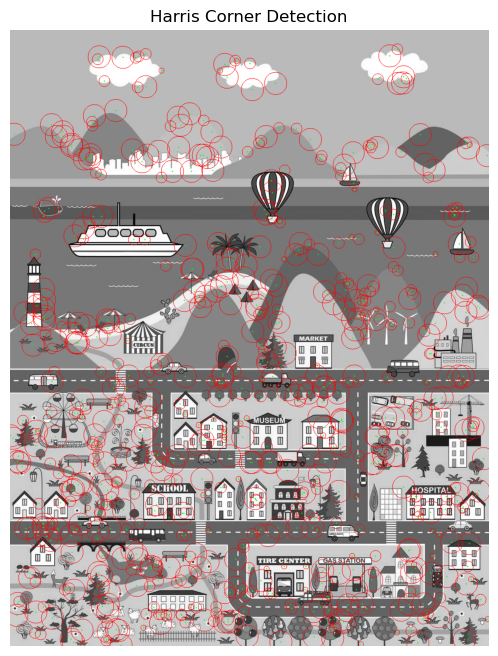

In [37]:
ksize = 5
k = .05

dx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=ksize)
dy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=ksize)
dx2 = dx ** 2
dy2 = dy ** 2
h_score = (dx2*dy2)-((dx*dy)**2)-k*((dx2+dy2)**2)
t = np.percentile(h_score.ravel(), 57.5)
h_score_t = np.where(h_score > t, h_score, 0)
rgb_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

candidate_xy = []
for y,x in np.argwhere(h_score_t):
    if (h_score[max(0,y-1):y+2, max(0,x-1):x+2] < h_score[y,x]).sum()==8:
        candidate_xy.append((y, x))

image64 = image.astype(np.float64)

norm_lap = []
sigmas = 2**np.arange(4) # 2**i, i=0..3
for s in sigmas:
    blurred = cv2.GaussianBlur(image64, (0, 0), s)
    lap = cv2.Laplacian(blurred, cv2.CV_64F, ksize=5)
    norm_lap.append((s ** 2) * np.abs(lap))
norm_lap = np.stack(norm_lap, axis=0)

keypoints = []
for (y, x) in candidate_xy:
    s_idx = np.argmax(norm_lap[:, y, x])
    keypoints.append((y, x, sigmas[s_idx]))

image_copy = rgb_image.copy()
for (y, x, sigma) in keypoints:
    r = max(2, int(round(3 * sigma)))
    cv2.circle(image_copy, (int(x), int(y)), r, (255, 0, 0), 1)
    cv2.circle(image_copy, (int(x), int(y)), 1, (0, 255, 0), -1)

plt.figure(figsize=(15, 8))
plt.imshow(image_copy)
plt.axis('off')
plt.title('Harris Corner Detection')
plt.show()